<a href="https://colab.research.google.com/github/shahidurrahmands/BNLTK/blob/main/BNLTK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Task Lists:**

1.   **Task-2: PDF Extraction & Verification**
2.   **Task 3: Section/Chapter Segmentation**
3.   **Task 4: Basic Cleanup & Formatting**
4.   **Task 5: Text Normalization & Spell Checking**
5.   **Task 6: Exploratory Data Analysis (EDA)**
6.   **Task 7: Tokenization & Sentence Splitting**
6.   **Task 8: Part-of-Speech (POS) Tagging**


**Task-2: PDF Extraction & Verification**

In [2]:
!pip install pdf2image pytesseract
!apt-get update
!apt-get install -y poppler-utils tesseract-ocr tesseract-ocr-ben

import os
import json
import shutil
import subprocess
import platform
from pdf2image import convert_from_path
import pytesseract

# Detect OS
is_windows = platform.system() == "Windows"

if is_windows:
    # Windows Paths
    tesseract_path = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
    poppler_path = r"C:\poppler-24.08.0\Library\bin"

    # Installl Tesseract
    if not os.path.exists(tesseract_path):
        raise FileNotFoundError("Tesseract-OCR not found. Install it from: https://github.com/UB-Mannheim/tesseract/wiki")

    pytesseract.pytesseract.tesseract_cmd = tesseract_path
    os.environ["TESSDATA_PREFIX"] = r"C:\Program Files\Tesseract-OCR\tessdata"
else:
    poppler_path = None
    pytesseract.pytesseract.tesseract_cmd = "/usr/bin/tesseract"
    os.environ["TESSDATA_PREFIX"] = "/usr/share/tesseract-ocr/4.00/tessdata/"

    # Install dependencies
    def install_dependencies():
        try:
            subprocess.run(["apt-get", "update"], check=True)
            subprocess.run(["apt-get", "install", "-y", "poppler-utils", "tesseract-ocr", "tesseract-ocr-ben"], check=True)
        except subprocess.CalledProcessError as e:
            print(f"Error installing dependencies: {e}")
            print("Please ensure you have the necessary permissions and a stable internet connection.")
            exit(1)

    install_dependencies()

# Paths
input_pdf = "/content/drive/MyDrive/Enternyship/Page1.pdf"
writable_pdf = "/content/drive/MyDrive/Enternyship/Output/Page1.pdf"

# Copy to writable directory
shutil.copy(input_pdf, writable_pdf)

def is_text_pdf(pdf_path):
    """Check if the PDF contains embedded text."""
    try:
        output = subprocess.run(["pdffonts", pdf_path], capture_output=True, text=True)
        return len(output.stdout.splitlines()) > 2
    except Exception as e:
        print(f"Error checking PDF type: {e}")
        print("Ensure 'poppler-utils' is installed and 'pdffonts' is in your PATH.")
        return False

def extract_text_pdf(pdf_path, output_txt):
    """Extract text from a text-based PDF."""
    try:
        subprocess.run(["pdftotext", pdf_path, output_txt], check=True)
        print(f"Extracted text saved to {output_txt}")
    except Exception as e:
        print(f"Error extracting text from PDF: {e}")
        print("Ensure 'poppler-utils' is installed and 'pdftotext' is in your PATH.")

def extract_text_ocr(pdf_path, output_json):
    """Extract text using OCR for a scanned PDF."""
    try:
        pages = convert_from_path(pdf_path, poppler_path=poppler_path if is_windows else None)
        extracted_text = {}

        # Bangla OCR
        for i, page in enumerate(pages):
            text = pytesseract.image_to_string(page, lang="ben")
            extracted_text[f"page_{i+1}"] = text.strip()

        with open(output_json, "w", encoding="utf-8") as f:
            json.dump(extracted_text, f, ensure_ascii=False, indent=4)

        print(f"OCR extracted text saved to {output_json}")
    except Exception as e:
        print(f"Error during OCR extraction: {e}")
        print("Ensure 'poppler-utils' is installed and 'pdf2image' is correctly configured.")

# Determine PDF type and extract text
output_text = "/content/drive/MyDrive/Enternyship/raw_extracted.txt"
output_json = "/content/drive/MyDrive/Enternyship/raw_extracted.json"

if is_text_pdf(writable_pdf):
    extract_text_pdf(writable_pdf, output_text)
else:
    extract_text_ocr(writable_pdf, output_json)

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,321 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,708 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,235 kB]
Get:13 http://archive.ubuntu.com/u

**Task 3: Section/Chapter Segmentation**

In [3]:
import json
import re

# Load extracted text
input_file = "/content/drive/MyDrive/Enternyship/raw_extracted.json"
output_file = "/content/drive/MyDrive/Enternyship/segmented_data.json"

with open(input_file, "r", encoding="utf-8") as f:
    extracted_data = json.load(f)

# Define segmentation rules
heading_patterns = [
    r"^(?:CHAPTER|SECTION)\s+\d+",
    r"^[০-৯]+\.",
    r"^[A-Z\s]+$",
]

# Function to split text into sections
def segment_text(text):
    sections = []
    current_section = ""

    lines = text.split("\n")
    for line in lines:
        if any(re.match(pattern, line.strip()) for pattern in heading_patterns):
            if current_section:
                sections.append(current_section.strip())
            current_section = line.strip()
        else:
            current_section += " " + line.strip()

    if current_section:
        sections.append(current_section.strip())

    return sections

# Process each page and segment text
segmented_data = {}
for page, text in extracted_data.items():
    segmented_data[page] = {"sections": segment_text(text)}

# Save segmented data
with open(output_file, "w", encoding="utf-8") as json_file:
    json.dump(segmented_data, json_file, ensure_ascii=False, indent=4)

print(f"Segmentation complete. Output saved to '{output_file}'.")


Segmentation complete. Output saved to '/content/drive/MyDrive/Enternyship/segmented_data.json'.


**Task 4: Basic Cleanup & Formatting**

In [4]:
import json
import re

# Load segmented data
input_file = "/content/drive/MyDrive/Enternyship/segmented_data.json"
output_file = "/content/drive/MyDrive/Enternyship/cleaned_segments.json"

with open(input_file, "r", encoding="utf-8") as f:
    segmented_data = json.load(f)

def ensure_utf8_encoding(text):
    return text.encode("utf-8", errors="ignore").decode("utf-8")

# Remove unnecessary spaces & merge lines
def clean_spaces(text):
    text = text.strip()
    text = re.sub(r"\n+", " ", text)
    return text

# Preserve paragraph structure
def preserve_paragraphs(text):
    text = re.sub(r"\n{2,}", "\n\n", text)
    return text

# Normalize Bangla punctuation and remove special characters
def handle_special_characters(text):
    # Remove control/invisible characters
    text = re.sub(r"[\u200B\u200C\u200D\u200E\u200F\u202A-\u202E\u2060-\u2064]+", "", text)
    # Normalize spacing around Bangla punctuation
    text = re.sub(r" ?([।ঃ,]) ?", r"\1 ", text)
    return text.strip()

cleaned_segments = {}

for page, page_data in segmented_data.items():
    if "sections" not in page_data:
        continue

    cleaned_sections = []
    for section in page_data["sections"]:
        section = ensure_utf8_encoding(section)
        section = clean_spaces(section)
        section = preserve_paragraphs(section)
        section = handle_special_characters(section)
        cleaned_sections.append(section)

    cleaned_segments[page] = {"sections": cleaned_sections}

# Save cleaned text
with open(output_file, "w", encoding="utf-8") as json_file:
    json.dump(cleaned_segments, json_file, ensure_ascii=False, indent=4)

print(f"Text cleanup complete. Cleaned data saved to '{output_file}'.")


Text cleanup complete. Cleaned data saved to '/content/drive/MyDrive/Enternyship/cleaned_segments.json'.


**Task 5: Text Normalization & Spell Checking**



In [5]:
import json
import re
import csv
import string
import unicodedata

# Load cleaned text
input_file = "/content/drive/MyDrive/Enternyship/cleaned_segments.json"
output_file = "/content/drive/MyDrive/Enternyship/normalized_text.json"
correction_log_file = "/content/drive/MyDrive/Enternyship/correction_log.csv"

# Load the cleaned segmented data from the JSON file
with open(input_file, "r", encoding="utf-8") as f:
    cleaned_data = json.load(f)

# Define common OCR errors and their corrections
common_errors = {
    "কৃওলা": "কুণ্ডলা",
    "কপালকৃওলা": "কপালকুণ্ডলা",
    "বিষবৃক্ষ": "বিষবৃক্ষ",
    "তীর": "তাঁর",
    "দুর্েশনন্দিনী": "দুর্গেশনন্দিনী",
    "অসামান্য কৃতিত্": "অসামান্য কৃতিত্ব",
    "প্রবন্ধগ্রস্থ": "প্রবন্ধগ্রন্থ",
    "গ্ণাগুণৃ": "গুণাগুণ",
    "দণ্ডর": "দণ্ড",
    "অবগ্ুপ্ঠনবতী": "অবগুণ্ঠনবতী",
    "স্থলপদ্র": "স্থলপদ্ম",
    "কন্যাকতা": "কন্যাকান্তা",
    "কলিকা-কন্যা": "কলিকা কন্যা",
    "মল্পিকা": "মল্লিকা",
}

# Stopwords for filtering
stopwords = [
    "এবং", "থেকে", "হয়", "নাহি", "কিন্তু", "থাক", "করিয়া",
    "হবে", "ছিল", "এটি", "এই", "এমন", "তুমি", "আমি", "তার",
    "নাহে", "অথবা", "করতে", "আমরা", "এমনকি"
]

# Remove zero-width characters
def remove_zero_width(text):
    return re.sub(r"[\u200B\u200C\u200D\u200E\u200F]", "", text)

# Remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans("", "", string.punctuation))

# Normalize Unicode characters
def normalize_unicode(text):
    return unicodedata.normalize("NFC", text)

# Correct common OCR errors
def correct_spelling(text):
    corrected_text = text
    corrections = []
    for incorrect, correct in common_errors.items():
        if incorrect in text:
            corrections.append((incorrect, correct))
            corrected_text = re.sub(r"\b" + re.escape(incorrect) + r"\b", correct, corrected_text)
    return corrected_text, corrections

# To apply normalization steps
def normalize_text(text):
    text = remove_zero_width(text)
    text = remove_punctuation(text)
    text = normalize_unicode(text)
    corrected_text, corrections = correct_spelling(text)
    return corrected_text, corrections

normalized_data = {}
correction_log = []

for page, page_data in cleaned_data.items():
    if "sections" not in page_data:
        continue

    normalized_sections = []
    for section in page_data["sections"]:
        # Apply normalization
        normalized_section, corrections = normalize_text(section)
        normalized_sections.append(normalized_section)

        # Log corrections
        correction_log.extend(corrections)

    normalized_data[page] = {"sections": normalized_sections}

# Save the normalized text to a JSON file
with open(output_file, "w", encoding="utf-8") as json_file:
    json.dump(normalized_data, json_file, ensure_ascii=False, indent=4)

# Save the correction log to a CSV file
with open(correction_log_file, "w", newline='', encoding="utf-8") as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(["Original Text", "Corrected Text"])
    for original, corrected in correction_log:
        writer.writerow([original, corrected])

print(f"Text normalization complete. Output saved to '{output_file}'.")
print(f"Correction log saved to '{correction_log_file}'.")

Text normalization complete. Output saved to '/content/drive/MyDrive/Enternyship/normalized_text.json'.
Correction log saved to '/content/drive/MyDrive/Enternyship/correction_log.csv'.


**Task 6: Exploratory Data Analysis (EDA)**

Text Statistics: {'Total Words': 290, 'Unique Words': 228, 'Average Sentence Length': 290.0, 'Max Sentence Length': 290, 'Min Sentence Length': 290}
Top Words: [('গুণ্', 6), ('বঙ্কিমচন্দ্র', 5), ('সালে', 4), ('করেন', 4), ('বড়', 4), ('না', 4), ('বলিলেন', 4), ('বিবাহ', 3), ('চট্টোপাধ্যায়', 3), ('তিনি', 3), ('তার', 3), ('বাংলা', 3), ('উপন্যাস', 3), ('বৃক্ষ', 3), ('করিয়া', 3), ('গুণৃ', 3), ('ফুলের', 2), ('হন', 2), ('ডেপুটি', 2), ('ও', 2)]


<ipython-input-6-1c91baaf113d>:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(counts), palette="viridis")


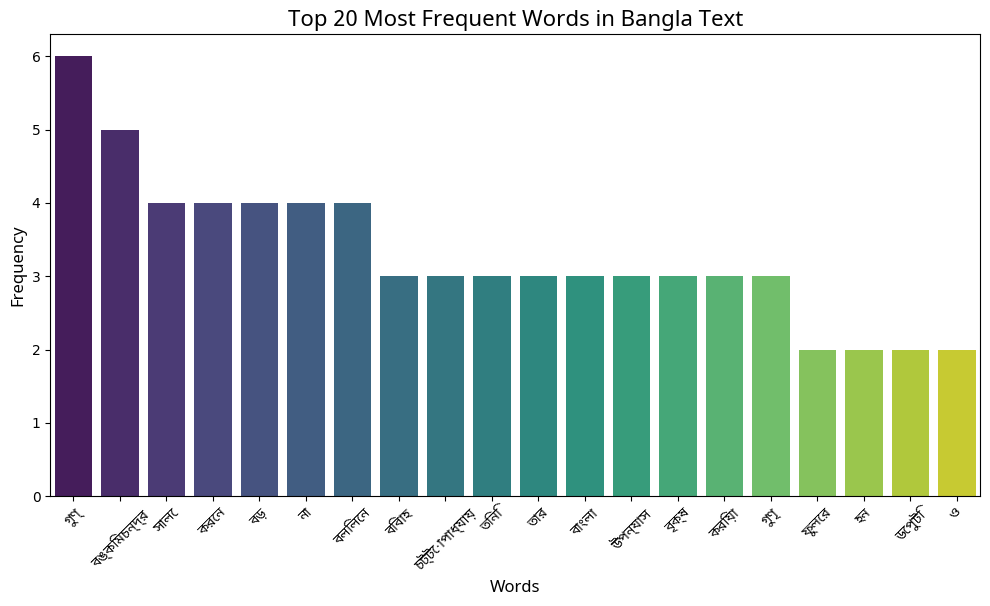

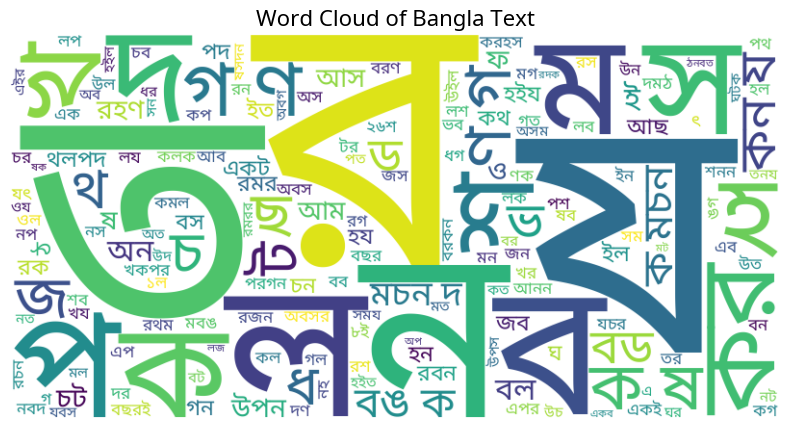

Anomalies Detected: [{'Page': 'page_1', 'Issue': 'Long sentence', 'Text': "{'sections': ['ফুলের বিবাহ  বঙ্কিমচন্দ্র চট্টোপাধ্যায়  লেখকপরিচিতি  বঙ্কিমচন্দ্র চট্টোপাধ্যায় ২৬শে..."}, {'Page': 'page_1', 'Issue': 'Rare characters', 'Text': "':[]ceinost{}।“”"}]
EDA report saved to /content/drive/MyDrive/Enternyship/eda_report.csv


In [6]:
import os
import json
import re
import pandas as pd
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import nltk
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

try:
    import numpy as np
except ImportError:
    import subprocess
    subprocess.check_call(['pip', 'install', 'numpy<2.0'])
    import numpy as np

# Download NLTK resources
try:
    nltk.data.find("tokenizers/punkt")
except LookupError:
    nltk.download("punkt")

# Define file paths
normalized_json = "/content/drive/MyDrive/Enternyship/normalized_text.json"
eda_report_csv = "/content/drive/MyDrive/Enternyship/eda_report.csv"
bengali_font_path = "/content/drive/MyDrive/Enternyship/bangla-font/static/NotoSansBengali-Regular.ttf"

# Check if the Bengali font file exists
font_prop = fm.FontProperties(fname=bengali_font_path) if os.path.exists(bengali_font_path) else None

def tokenize_text(text):
    """Tokenizes and cleans Bangla text."""
    if not isinstance(text, str):
        text = str(text)
    text = re.sub(r"[^\u0980-\u09FF\s]", "", text)
    return text.split()

# Calculate basic text statistics
def calculate_text_stats(text_data):
    """Computes word count, unique vocabulary size, and sentence statistics."""
    all_words = []
    sentence_lengths = []

    for text in text_data.values():
        words = tokenize_text(text)
        all_words.extend(words)
        sentence_lengths.append(len(words))

    unique_words = set(all_words)

    return {
        "Total Words": len(all_words),
        "Unique Words": len(unique_words),
        "Average Sentence Length": sum(sentence_lengths) / len(sentence_lengths) if sentence_lengths else 0,
        "Max Sentence Length": max(sentence_lengths) if sentence_lengths else 0,
        "Min Sentence Length": min(sentence_lengths) if sentence_lengths else 0,
    }

# Perform frequency analysis
def word_frequencies(text_data, top_n=20):
    """Finds the most frequent words."""
    all_words = []

    for text in text_data.values():
        words = tokenize_text(text)
        all_words.extend(words)

    word_counts = Counter(all_words)
    return word_counts.most_common(top_n)

# To generate visualizations
def generate_visualizations(text_data):
    """Creates histograms and word clouds for word frequency analysis."""
    all_words = []

    for text in text_data.values():
        words = tokenize_text(text)
        all_words.extend(words)

    word_counts = Counter(all_words)
    top_words = word_counts.most_common(20)

    if not top_words:
        print( "No words found for visualization.")
        return

    words, counts = zip(*top_words)

    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(words), y=list(counts), palette="viridis")

    if font_prop:
        plt.title("Top 20 Most Frequent Words in Bangla Text", fontproperties=font_prop, fontsize=16)
        plt.xlabel("Words", fontproperties=font_prop, fontsize=12)
        plt.ylabel("Frequency", fontproperties=font_prop, fontsize=12)
        plt.xticks(rotation=45, fontproperties=font_prop)
    else:
        plt.title("Top 20 Most Frequent Words in Bangla Text", fontsize=16)
        plt.xlabel("Words", fontsize=12)
        plt.ylabel("Frequency", fontsize=12)
        plt.xticks(rotation=45)

    plt.savefig("/content/drive/MyDrive/Enternyship/top_words.png")
    plt.show()

    # Generate Word Cloud
    wordcloud = WordCloud(
        font_path=bengali_font_path if os.path.exists(bengali_font_path) else None,
        width=800, height=400, background_color="white"
    ).generate(" ".join(all_words))

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")

    if font_prop:
        plt.title("Word Cloud of Bangla Text", fontproperties=font_prop, fontsize=16)
    else:
        plt.title("Word Cloud of Bangla Text", fontsize=16)

    plt.savefig("/content/drive/MyDrive/Enternyship/wordcloud.png")
    plt.show()

# To detect anomalies
def detect_anomalies(text_data):
    """Identifies long sentences and rare characters."""
    anomalies = []

    for page, text in text_data.items():
        text = str(text)
        words = tokenize_text(text)

        if len(words) > 50:
            anomalies.append({"Page": page, "Issue": "Long sentence", "Text": text[:100] + "..."})

        rare_chars = sorted(set(re.findall(r"[^\u0980-\u09FF\s]", text)))
        if rare_chars:
            anomalies.append({"Page": page, "Issue": "Rare characters", "Text": "".join(rare_chars)})

    return anomalies

# Main function to run EDA
def main():
    if not os.path.exists(normalized_json):
        print(f"Error: Normalized file '{normalized_json}' was not found.")
        return

    try:
        with open(normalized_json, "r", encoding="utf-8") as f:
            text_data = json.load(f)

        if not text_data or not isinstance(text_data, dict):
            print("Error: Normalized text file is empty or has an invalid format.")
            return

        # Compute basic statistics
        text_stats = calculate_text_stats(text_data)
        print(f"Text Statistics: {text_stats}")

        # Perform word frequency analysis
        frequent_words = word_frequencies(text_data)
        print(f"Top Words: {frequent_words}")

        # Generate visualizations
        generate_visualizations(text_data)

        # Detect anomalies
        anomalies = detect_anomalies(text_data)
        print(f"Anomalies Detected: {anomalies}")

        # Save EDA Report as CSV
        eda_data = pd.DataFrame([text_stats])
        eda_data.to_csv(eda_report_csv, index=False)

        print(f"EDA report saved to {eda_report_csv}")

    except json.JSONDecodeError:
        print(f" Error: Failed to parse '{normalized_json}'. Ensure it's a valid JSON file.")
    except Exception as e:
        print(f"Unexpected error: {e}")

# Run script
if __name__ == "__main__":
    main()


 **Task 7: Tokenization & Sentence Splitting**

Tokenizing Bangla Text into Sentences and Words using the Indic NLP Library

In [7]:
!pip install indic-nlp-library

import json
from indicnlp.tokenize import sentence_tokenize
from indicnlp.tokenize import indic_tokenize

import nltk
nltk.download('punkt')

# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

# Load the normalized text data
normalized_file = "/content/drive/MyDrive/Enternyship/normalized_text.json"

with open(normalized_file, "r", encoding="utf-8") as file:
    normalized_data = json.load(file)

# Function to tokenize sentences and words using Indic NLP Library
def tokenize_text(normalized_data):
    tokenized_data = {}

    for page, page_data in normalized_data.items():
        tokenized_page = {"sentences": []}
        for section in page_data["sections"]:
            sentences = sentence_tokenize.sentence_split(section, lang='bn')
            tokenized_sentences = [indic_tokenize.trivial_tokenize(sentence) for sentence in sentences]
            tokenized_page["sentences"].extend(tokenized_sentences)

        tokenized_data[page] = tokenized_page

    return tokenized_data

# Tokenize the normalized text
tokenized_data = tokenize_text(normalized_data)

# Save tokenized data to a JSON file
tokenized_file = "/content/drive/MyDrive/Enternyship/tokenized_text.json"

with open(tokenized_file, "w", encoding="utf-8") as file:
    json.dump(tokenized_data, file, ensure_ascii=False, indent=4)

print(f"Tokenization complete. Tokenized data saved to '{tokenized_file}'.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 10.3 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Tokenization complete. Tokenized data saved to '/content/drive/MyDrive/Enternyship/tokenized_text.json'.


Tokenizing Bangla text and identifying sentence boundaries

In [8]:
import json
import re
import nltk
from nltk.tokenize import regexp_tokenize


nltk.download("punkt")

input_file = "/content/drive/MyDrive/Enternyship/normalized_text.json"

with open(input_file, "r", encoding="utf-8") as f:
    normalized_data = json.load(f)

all_text = " ".join([section for page_data in normalized_data.values() for section in page_data["sections"]])

# Step 1: Implement Tokenizer

def bangla_tokenizer(text):
    """
    Custom Bangla tokenizer handling punctuation, numbers, emoticons, and word tokenization.
    """
    # Define regex patterns for tokenization
    token_pattern = r"\w+|[^\w\s]"

    # Tokenize text using the defined pattern
    tokens = regexp_tokenize(text, token_pattern)

    return tokens

# Step 2: Sentence Splitting
def split_sentences(text):
    """
    Splits text into sentences based on Bangla sentence delimiters (e.g., full stop, exclamation marks, question marks).
    """
    # Sentence delimiters for Bangla
    sentence_endings = r"[।!?]"

    # Split text using the sentence delimiters
    sentences = re.split(sentence_endings, text)
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]

    return sentences

# Step 3:
sentences = split_sentences(all_text)

# Tokenize each sentence
tokenized_data = {}
for idx, sentence in enumerate(sentences):
    tokens = bangla_tokenizer(sentence)
    tokenized_data[f"sentence_{idx + 1}"] = tokens

# Sentence Boundaries
sentence_boundaries = [{"sentence": sentence, "start": all_text.find(sentence), "end": all_text.find(sentence) + len(sentence)}
                       for sentence in sentences]

# Print sentence boundaries
print("Sentence Boundaries (Start and End Positions):")
for i, boundary in enumerate(sentence_boundaries, start=1):
    print(f"Sentence {i}: {boundary['sentence']}")
    print(f"  Start: {boundary['start']}, End: {boundary['end']}")
    print("-" * 50)

# Save sentence boundaries
boundary_output_file = "/content/drive/MyDrive/Enternyship/sentence_boundaries.json"
with open(boundary_output_file, "w", encoding="utf-8") as f:
    json.dump(sentence_boundaries, f, ensure_ascii=False, indent=4)

print(f"Tokenized data saved to {output_file}")
print(f"Sentence boundaries saved to {boundary_output_file}")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Sentence Boundaries (Start and End Positions):
Sentence 1: ফুলের বিবাহ  বঙ্কিমচন্দ্র চট্টোপাধ্যায়  লেখকপরিচিতি  বঙ্কিমচন্দ্র চট্টোপাধ্যায় ২৬শে জুন ১৮৩৮ সালে পশ্চিমবঙ্গের চব্বিশ পরগনা জেলার অন্তর্গত কীঠালপাড়া গ্রামে জন্মগ্রহণ করেন
  Start: 0, End: 173
--------------------------------------------------
Sentence 2: তিনি ১৮৫৮ সালে কলকাতা বিশ্ববিদ্যালয় থেকে বিএপরীক্ষায় উত্তাঁর্ণ হন এবং সে বছরই ডেপুটি ম্যাজিস্ট্রেট ও ডেপুটি কালেক্টর পদে চাকরিতে নিযুক্ত হন
  Start: 175, End: 316
--------------------------------------------------
Sentence 3: বঙ্কিমচন্দ্র তেত্রিশ বছর একই পদে চাকরি করে ১৮৯১ সালে অবসর গ্রহণ করেন
  Start: 318, End: 386
--------------------------------------------------
Sentence 4: তিনি পাঠ্যাবস্থায়ই সাহিত্যচর্চা শুরু করেন
  Start: 388, End: 430
--------------------------------------------------
Sentence 5: তার অসামান্য কৃতিত্ প্রকাশ পেয়েছে পাশ্চাত্য ভাবাদর্শে বাংলা উপন্যাস রচনার পথিকৃৎ হিসেবে
  Start: 432, End: 520
--------------------------------------------------
Sentence

Tokenizing Bangla text into sentences using custom rules for punctuation

In [9]:
import json
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import re

nltk.download("punkt")
nltk.download('punkt_tab')

# Load normalized text
input_file = "/content/drive/MyDrive/Enternyship/normalized_text.json"

with open(input_file, "r", encoding="utf-8") as f:
    normalized_data = json.load(f)

# Combine all sections into one text block
all_text = " ".join([section for page_data in normalized_data.values() for section in page_data["sections"]])

# Step 1: Implement Sentence Tokenizer
def bangla_sentence_tokenizer(text):
    """
    Custom Bangla sentence tokenizer that handles punctuation like '।', '!', and '?'.
    """
    # Using NLTK's sentence tokenizer
    sentences = sent_tokenize(text, language='english')  # Using English tokenizer as NLTK doesn't have Bangla by default

    # Ensuring Bangla punctuation
    bangla_punctuation = ['।', '!', '?', '.', '।']
    sentence_endings = re.compile(r'([{}]+)'.format(''.join(bangla_punctuation)))

    sentences = sentence_endings.split(text)
    sentences = [s.strip() for s in sentences if s.strip()]

    return sentences

# Step 2: Process All Text

# Tokenize the full text into sentences
sentences = bangla_sentence_tokenizer(all_text)

# Output: Print some sentences to verify
print("Sample Sentences from the Text:")
for sentence in sentences[:100]:
    print(sentence)

# Save Tokenized Sentences
output_file = "/content/drive/MyDrive/Enternyship/sentence_tokenized_data.json"
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(sentences, f, ensure_ascii=False, indent=4)

print(f"Sentence tokenized data saved to {output_file}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Sample Sentences from the Text:
ফুলের বিবাহ  বঙ্কিমচন্দ্র চট্টোপাধ্যায়  লেখকপরিচিতি  বঙ্কিমচন্দ্র চট্টোপাধ্যায় ২৬শে জুন ১৮৩৮ সালে পশ্চিমবঙ্গের চব্বিশ পরগনা জেলার অন্তর্গত কীঠালপাড়া গ্রামে জন্মগ্রহণ করেন
।
তিনি ১৮৫৮ সালে কলকাতা বিশ্ববিদ্যালয় থেকে বিএপরীক্ষায় উত্তাঁর্ণ হন এবং সে বছরই ডেপুটি ম্যাজিস্ট্রেট ও ডেপুটি কালেক্টর পদে চাকরিতে নিযুক্ত হন
।
বঙ্কিমচন্দ্র তেত্রিশ বছর একই পদে চাকরি করে ১৮৯১ সালে অবসর গ্রহণ করেন
।
তিনি পাঠ্যাবস্থায়ই সাহিত্যচর্চা শুরু করেন
।
তার অসামান্য কৃতিত্ প্রকাশ পেয়েছে পাশ্চাত্য ভাবাদর্শে বাংলা উপন্যাস রচনার পথিকৃৎ হিসেবে
।
১৮৬৫ সালে প্রকাশিত তাঁর প্রথম বাংলা উপন্যাস দুর্েশনন্দিনী বাংলা কথাসাহিত্যে এক নবদিগন্ত উন্মোচন করে
।
তার অন্যান্য উপন্যাস হলো কপালকৃওলা মৃণালিনী বিষবৃক্ষ ইন্দিরা যুগলাঙগুরীয় রাধারানী চন্দ্রশেখর রজনী কৃষ্ণকান্তের উইল রাজসিংহ আনন্দমঠ দেবী চৌধুরানী ও সীতারাম
।
প্রবন্ধ সাহিত্যেও বঙ্কিমচন্দ্র কৃতিত্ব দেখিয়েছেন
।
কমলাকান্তের দণ্ড লোকরহস্য কৃষ্ণ চরিত্র ইত্যাদি তার উল্লেখযোগ্য প্রবন্ধগ্রন্থ
।
বঙ্কিমচন্দ্র চট্টোপাধ্যায় ১৮৯৪ সালের ৮ই এপ্রিল মৃ

Tokenizing Bangla text into words using NLTK's word tokenizer

In [10]:
import json
import nltk
from nltk.tokenize import word_tokenize

nltk.download("punkt")

input_file = "/content/drive/MyDrive/Enternyship/normalized_text.json"

with open(input_file, "r", encoding="utf-8") as f:
    normalized_data = json.load(f)

all_text = " ".join([section for page_data in normalized_data.values() for section in page_data["sections"]])

# Step 1: Word Tokenizer
def bangla_word_tokenizer(text):
    """
    Custom Bangla word tokenizer that handles punctuation and spaces properly.
    """
    words = word_tokenize(text)
    return words

# Step 2: Process All Text
words = bangla_word_tokenizer(all_text)

# Output: Print a Sample of Tokenized Words
print("Sample Tokenized Words from the Text:")
for word in words[:290]:
    print(word)

# Save Tokenized Words
output_file = "/content/drive/MyDrive/Enternyship/word_tokenized_data.json"
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(words, f, ensure_ascii=False, indent=4)

print(f"Word tokenized data saved to {output_file}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Sample Tokenized Words from the Text:
ফুলের
বিবাহ
বঙ্কিমচন্দ্র
চট্টোপাধ্যায়
লেখকপরিচিতি
বঙ্কিমচন্দ্র
চট্টোপাধ্যায়
২৬শে
জুন
১৮৩৮
সালে
পশ্চিমবঙ্গের
চব্বিশ
পরগনা
জেলার
অন্তর্গত
কীঠালপাড়া
গ্রামে
জন্মগ্রহণ
করেন।
তিনি
১৮৫৮
সালে
কলকাতা
বিশ্ববিদ্যালয়
থেকে
বিএপরীক্ষায়
উত্তাঁর্ণ
হন
এবং
সে
বছরই
ডেপুটি
ম্যাজিস্ট্রেট
ও
ডেপুটি
কালেক্টর
পদে
চাকরিতে
নিযুক্ত
হন।
বঙ্কিমচন্দ্র
তেত্রিশ
বছর
একই
পদে
চাকরি
করে
১৮৯১
সালে
অবসর
গ্রহণ
করেন।
তিনি
পাঠ্যাবস্থায়ই
সাহিত্যচর্চা
শুরু
করেন।
তার
অসামান্য
কৃতিত্
প্রকাশ
পেয়েছে
পাশ্চাত্য
ভাবাদর্শে
বাংলা
উপন্যাস
রচনার
পথিকৃৎ
হিসেবে।
১৮৬৫
সালে
প্রকাশিত
তাঁর
প্রথম
বাংলা
উপন্যাস
দুর্েশনন্দিনী
বাংলা
কথাসাহিত্যে
এক
নবদিগন্ত
উন্মোচন
করে।
তার
অন্যান্য
উপন্যাস
হলো
কপালকৃওলা
মৃণালিনী
বিষবৃক্ষ
ইন্দিরা
যুগলাঙগুরীয়
রাধারানী
চন্দ্রশেখর
রজনী
কৃষ্ণকান্তের
উইল
রাজসিংহ
আনন্দমঠ
দেবী
চৌধুরানী
ও
সীতারাম।
প্রবন্ধ
সাহিত্যেও
বঙ্কিমচন্দ্র
কৃতিত্ব
দেখিয়েছেন।
কমলাকান্তের
দণ্ড
লোকরহস্য
কৃষ্ণ
চরিত্র
ইত্যাদি
তার
উল্লেখযোগ্য
প্রবন্ধগ্রন্থ।
বঙ্কিমচন্দ্র
চট্টোপাধ্যায়
১৮৯৪
সালের
৮ই
এপ্রিল
মৃত্যুবর

Tokenizing Bangla text into words using NLTK's word tokenizer

In [11]:
nltk.download('wordnet')
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

import json
import nltk
from nltk.tokenize import word_tokenize

input_file = "/content/drive/MyDrive/Enternyship/normalized_text.json"

with open(input_file, "r", encoding="utf-8") as f:
    normalized_data = json.load(f)

all_text = " ".join([section for page_data in normalized_data.values() for section in page_data["sections"]])

# Step 1: Word Tokenizer
def bangla_word_tokenizer(text):
    """
    Custom Bangla word tokenizer that handles punctuation and spaces properly.
    """
    words = word_tokenize(text)
    return words

# Step 2: Simple Bangla Lemmatization
def simple_bangla_lemmatizer(word):
    """
    A simple approach to lemmatize Bangla words by removing common suffixes.
    This is not a perfect solution but provides a basic method.
    """
    suffixes = ['গুলো', 'টি', 'টি', 'রা', 'টা', 'টা', 'টি', 'তে', 'তেও', 'দের', 'ও', 'ই', 'না']
    for suffix in suffixes:
        if word.endswith(suffix):
            return word[:-len(suffix)]
    return word

def lemmatize_tokens(tokens):
    """
    Lemmatizes tokens using the simple Bangla lemmatizer.
    """
    return [simple_bangla_lemmatizer(token) for token in tokens]

# Step 3: Process All Text
sentences = nltk.sent_tokenize(all_text)

lemmatized_sentences = []

for sentence in sentences:
    words = bangla_word_tokenizer(sentence)
    lemmatized_words = lemmatize_tokens(words)
    lemmatized_sentences.append(" ".join(lemmatized_words))

# Output: Print a Sample of Lemmatized Sentences
print("Sample Lemmatized Sentences:")
for sentence in lemmatized_sentences[:5]:
    print(sentence)

# Save Lemmatized Sentences
output_file = "/content/drive/MyDrive/Enternyship/lemmatized_sentences_bangla.json"
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(lemmatized_sentences, f, ensure_ascii=False, indent=4)

print(f"Lemmatized sentences saved to {output_file}")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Sample Lemmatized Sentences:
ফুলের বিবাহ বঙ্কিমচন্দ্র চট্টোপাধ্যায় লেখকপরিচিতি বঙ্কিমচন্দ্র চট্টোপাধ্যায় ২৬শে জুন ১৮৩৮ সালে পশ্চিমবঙ্গের চব্বিশ পরগ জেলার অন্তর্গত কীঠালপাড়া গ্রামে জন্মগ্রহণ করেন। তিনি ১৮৫৮ সালে কলকাতা বিশ্ববিদ্যালয় থেকে বিএপরীক্ষায় উত্তাঁর্ণ হন এবং সে বছর ডেপু ম্যাজিস্ট্রেট  ডেপু কালেক্টর পদে চাকরি নিযুক্ত হন। বঙ্কিমচন্দ্র তেত্রিশ বছর এক পদে চাকরি করে ১৮৯১ সালে অবসর গ্রহণ করেন। তিনি পাঠ্যাবস্থায় সাহিত্যচর্চা শুরু করেন। তার অসামান্য কৃতিত্ প্রকাশ পেয়েছে পাশ্চাত্য ভাবাদর্শে বাংলা উপন্যাস রচনার পথিকৃৎ হিসেবে। ১৮৬৫ সালে প্রকাশিত তাঁর প্রথম বাংলা উপন্যাস দুর্েশনন্দিনী বাংলা কথাসাহিত্যে এক নবদিগন্ত উন্মোচন করে। তার অন্যান্য উপন্যাস হলো কপালকৃওলা মৃণালিনী বিষবৃক্ষ ইন্দি যুগলাঙগুরীয় রাধারানী চন্দ্রশেখর রজনী কৃষ্ণকান্তের উইল রাজসিংহ আনন্দমঠ দেবী চৌধুরানী  সীতারাম। প্রবন্ধ সাহিত্যে বঙ্কিমচন্দ্র কৃতিত্ব দেখিয়েছেন। কমলাকান্তের দণ্ড লোকরহস্য কৃষ্ণ চরিত্র ইত্যাদি তার উল্লেখযোগ্য প্রবন্ধগ্রন্থ। বঙ্কিমচন্দ্র চট্টোপাধ্যায় ১৮৯৪ সালের ৮ এপ্রিল মৃত্যুবরণ করেন বৈশাখ মাস বিবাহের ম

Lemmatizing Bangla text by tokenizing words and removing common suffixes

In [12]:
import json
import nltk
from nltk.tokenize import word_tokenize

input_file = "/content/drive/MyDrive/Enternyship/normalized_text.json"

with open(input_file, "r", encoding="utf-8") as f:
    normalized_data = json.load(f)

all_text = " ".join([section for page_data in normalized_data.values() for section in page_data["sections"]])

# Step 1: Word Tokenizer
def bangla_word_tokenizer(text):
    """
    Custom Bangla word tokenizer that handles punctuation and spaces properly.
    """
    words = word_tokenize(text)
    return words

# Step 2: Simple Bangla Lemmatization
def simple_bangla_lemmatizer(word):
    """
    A simple approach to lemmatize Bangla words by removing common suffixes.
    This is not a perfect solution but provides a basic method.
    """
    suffixes = ['গুলো', 'টি', 'টি', 'রা', 'টা', 'টা', 'টি', 'তে', 'তেও', 'দের', 'ও', 'ই', 'না']
    for suffix in suffixes:
        if word.endswith(suffix):
            return word[:-len(suffix)]
    return word

def lemmatize_tokens(tokens):
    """
    Lemmatizes tokens using the simple Bangla lemmatizer.
    """
    return [simple_bangla_lemmatizer(token) for token in tokens]

# Step 3: Process All Text
sentences = nltk.sent_tokenize(all_text)

lemmatized_sentences = []

for sentence in sentences:
    words = bangla_word_tokenizer(sentence)
    lemmatized_words = lemmatize_tokens(words)
    lemmatized_sentences.append(" ".join(lemmatized_words))

# Output: Print a Sample of Lemmatized Sentences
print("/content/drive/MyDrive/Enternyship/Sample Lemmatized Sentences:")
for sentence in lemmatized_sentences[:5]:
    print(sentence)

# Save Lemmatized Sentences to a Text File
output_file = "/content/drive/MyDrive/Enternyship/lemmatized_sentences_bangla.txt"
with open(output_file, "w", encoding="utf-8") as f:
    for sentence in lemmatized_sentences:
        f.write(sentence + "\n")

print(f"Lemmatized sentences saved to {output_file}")


/content/drive/MyDrive/Enternyship/Sample Lemmatized Sentences:
ফুলের বিবাহ বঙ্কিমচন্দ্র চট্টোপাধ্যায় লেখকপরিচিতি বঙ্কিমচন্দ্র চট্টোপাধ্যায় ২৬শে জুন ১৮৩৮ সালে পশ্চিমবঙ্গের চব্বিশ পরগ জেলার অন্তর্গত কীঠালপাড়া গ্রামে জন্মগ্রহণ করেন। তিনি ১৮৫৮ সালে কলকাতা বিশ্ববিদ্যালয় থেকে বিএপরীক্ষায় উত্তাঁর্ণ হন এবং সে বছর ডেপু ম্যাজিস্ট্রেট  ডেপু কালেক্টর পদে চাকরি নিযুক্ত হন। বঙ্কিমচন্দ্র তেত্রিশ বছর এক পদে চাকরি করে ১৮৯১ সালে অবসর গ্রহণ করেন। তিনি পাঠ্যাবস্থায় সাহিত্যচর্চা শুরু করেন। তার অসামান্য কৃতিত্ প্রকাশ পেয়েছে পাশ্চাত্য ভাবাদর্শে বাংলা উপন্যাস রচনার পথিকৃৎ হিসেবে। ১৮৬৫ সালে প্রকাশিত তাঁর প্রথম বাংলা উপন্যাস দুর্েশনন্দিনী বাংলা কথাসাহিত্যে এক নবদিগন্ত উন্মোচন করে। তার অন্যান্য উপন্যাস হলো কপালকৃওলা মৃণালিনী বিষবৃক্ষ ইন্দি যুগলাঙগুরীয় রাধারানী চন্দ্রশেখর রজনী কৃষ্ণকান্তের উইল রাজসিংহ আনন্দমঠ দেবী চৌধুরানী  সীতারাম। প্রবন্ধ সাহিত্যে বঙ্কিমচন্দ্র কৃতিত্ব দেখিয়েছেন। কমলাকান্তের দণ্ড লোকরহস্য কৃষ্ণ চরিত্র ইত্যাদি তার উল্লেখযোগ্য প্রবন্ধগ্রন্থ। বঙ্কিমচন্দ্র চট্টোপাধ্যায় ১৮৯৪ সালের ৮ এপ্রিল

Performing Part-of-Speech (POS) tagging on lemmatized Bangla text and saving the results in a formatted file

In [13]:
!pip install nltk
import nltk
nltk.download('averaged_perceptron_tagger')
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger_eng')

# File path
input_file_path = "/content/drive/MyDrive/Enternyship/lemmatized_sentences_bangla.txt"
output_file_path = "/content/drive/MyDrive/Enternyship/pos_tagging.txt"

# Read lemmatized words from a file
def read_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        return f.read()

input_text = read_file(input_file_path)
tokens = word_tokenize(input_text)

# POS to Bengali Tag Mapping
POS_TAG_MAP_BANGLA = {
    'NN': 'Noun',
    'NNS': 'Noun (Plural)',
    'NNP': 'Proper Noun',
    'NNPS': 'Proper Noun (Plural)',
    'VB': 'Verb',
    'VBD': 'Verb (Past)',
    'VBG': 'Verb (Gerund)',
    'VBN': 'Verb (Past Participle)',
    'VBP': 'Verb (Present)',
    'VBZ': 'Verb (3rd Person Present)',
    'JJ': 'Adjective',
    'JJR': 'Adjective (Comparative)',
    'JJS': 'Adjective (Superlative)',
    'RB': 'Adverb',
    'RBR': 'Adverb (Comparative)',
    'RBS': 'Adverb (Superlative)',
    'PRP': 'Pronoun',
    'PRP$': 'Pronoun (Possessive)',
    'WP': 'Wh-Pronoun',
    'WP$': 'Wh-Possessive',
    'WRB': 'Wh-Adverb',
    'IN': 'Preposition',
    'CC': 'Conjunction',
    'DT': 'Determiner',
    'UH': 'Interjection',
    'CD': 'Cardinal Number',
    'FW': 'Foreign Word',
    'MD': 'Modal',
}

# Apply POS tagging
def custom_pos_tagging(tokens):
    standard_pos_tags = nltk.pos_tag(tokens)
    custom_tags = [(word, POS_TAG_MAP_BANGLA.get(tag, 'Other')) for word, tag in standard_pos_tags]
    return custom_tags

# Apply POS tagging to the tokens
custom_pos_tags = custom_pos_tagging(tokens)

# Save outputs with beautiful formatting
def save_to_file(data, file_name, beautiful=False):
    with open(file_name, 'w', encoding='utf-8') as f:
        if beautiful and all(isinstance(i, tuple) for i in data):  # Check if it's a list of tuples
            word_width = 20
            tag_width = 20
            divider = f"+{'-' * word_width}+{'-' * tag_width}+"

            # Write header
            f.write(divider + "\n")
            f.write(f"|{'Word'.center(word_width)}|{'POS Tag'.center(tag_width)}|\n")
            f.write(divider + "\n")

            # Write word-tag pairs in a table format
            for word, tag in data:
                f.write(f"|{word.center(word_width)}|{tag.center(tag_width)}|\n")

            # Add closing divider
            f.write(divider + "\n")

        elif isinstance(data, list):
            if all(isinstance(i, tuple) for i in data):  # For word-tag pairs
                for word, tag in data:
                    f.write(f"{word}: {tag}\n")
            else:  # For normal tokens
                f.write("\n".join(data))
        elif isinstance(data, str):
            f.write(data)

# Save POS-tagged output
save_to_file(custom_pos_tags, output_file_path, beautiful=True)

print("+--------------------+--------------------+")
print("\n POS tagging completed successfully! Data saved in '/content/drive/MyDrive/Enternyship/pos_tagging.txt'.")

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


+--------------------+--------------------+

 POS tagging completed successfully! Data saved in '/content/drive/MyDrive/Enternyship/pos_tagging.txt'.


POS tagging lemmatized Bangla text and saving the results with Bengali tags

In [15]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# File paths for input and output
input_file_path = "/content/drive/MyDrive/Enternyship/lemmatized_sentences_bangla.json"
output_file_path = "/content/drive/MyDrive/Enternyship/pos_tagging.txt"

# Function to read the lemmatized words from the file
def read_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        return f.read()

input_text = read_file(input_file_path)
tokens = word_tokenize(input_text)

# POS to Bengali Tag Mapping
POS_TAG_MAP_BANGLA = {
    'NN': 'বিশেষ্য',
    'NNS': 'বহুবচন বিশেষ্য',
    'NNP': 'নিজস্ব বিশেষ্য',
    'NNPS': 'নিজস্ব বহুবচন বিশেষ্য',
    'VB': 'ক্রিয়া',
    'VBD': 'অতীত ক্রিয়া',
    'VBG': 'গেরুন্ড ক্রিয়া',
    'VBN': 'অতীত সম্পূর্ণ ক্রিয়া',
    'VBP': 'বর্তমান ক্রিয়া',
    'VBZ': 'তৃতীয় পুরুষ বর্তমান ক্রিয়া',
    'JJ': 'বিশেষণ',
    'JJR': 'তুলনামূলক বিশেষণ',
    'JJS': 'সর্বোচ্চ বিশেষণ',
    'RB': 'ক্রিয়া বিশেষণ',
    'RBR': 'তুলনামূলক ক্রিয়া বিশেষণ',
    'RBS': 'সর্বোচ্চ ক্রিয়া বিশেষণ',
    'PRP': 'সর্বনাম',
    'PRP$': 'অধিকারসূচক সর্বনাম',
    'WP': 'প্রশ্নসূচক সর্বনাম',
    'WP$': 'প্রশ্নসূচক অধিকারসূচক',
    'WRB': 'প্রশ্নসূচক ক্রিয়া বিশেষণ',
    'IN': 'অব্যয়',
    'CC': 'সংযোজক',
    'DT': 'নির্দেশক',
    'UH': 'আবেগসূচক শব্দ',
    'CD': 'সংখ্যা',
    'FW': 'বিদেশী শব্দ',
    'MD': 'সহায়ক ক্রিয়া',
}

# Apply POS tagging and map to Bengali tags
def custom_pos_tagging(tokens):
    standard_pos_tags = nltk.pos_tag(tokens)
    custom_tags = [(word, POS_TAG_MAP_BANGLA.get(tag, 'অন্যান্য')) for word, tag in standard_pos_tags]
    return custom_tags

# Apply POS tagging to the tokenized words
custom_pos_tags = custom_pos_tagging(tokens)

# Function to save the POS-tagged output to a file
def save_to_file(data, file_name):
    with open(file_name, 'w', encoding='utf-8') as f:
        f.write("[[\n")
        formatted_output = []
        for word, tag in data:
            formatted_output.append(f"('{word}', '{tag}')")
        f.write(", ".join(formatted_output))
        f.write("\n]]")

# Save the POS-tagged output to the specified file
save_to_file(custom_pos_tags, output_file_path)

# Print success message
print("\nPOS tagging completed successfully! Results saved in '/content/drive/MyDrive/Enternyship/pos_tagging.txt'.")



POS tagging completed successfully! Results saved in '/content/drive/MyDrive/Enternyship/pos_tagging.txt'.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Train a CRF model for Bengali POS tagging, evaluate its performance, and predict tags for new sentences.

In [16]:
!pip install sklearn-crfsuite
import pandas as pd
import sklearn_crfsuite
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Sample labeled Bengali sentence for POS tagging
data = [
    ("বঙ্কিমচন্দ্র", "NOUN"),
    ("চট্টোপাধ্যায়", "NOUN"),
    ("২৬শে", "NUM"),
    ("জুন", "NOUN"),
    ("১৮৩৮", "NUM"),
    ("সালে", "NOUN"),
    ("পশ্চিমবঙ্গের", "ADJ"),
    ("চব্বিশ", "NUM"),
    ("পরগনা", "NOUN"),
    ("জেলার", "ADJ"),
    ("অন্তর্গত", "ADJ"),
    ("কীঠালপাড়া", "NOUN"),
    ("গ্রামে", "NOUN"),
    ("জন্মগ্রহণ", "VERB"),
    ("করেন", "VERB")
]

df = pd.DataFrame(data, columns=["Word", "POS"])

def extract_features(sentence, index):
    """Extract contextual features for a given word in a sentence."""
    word = sentence[index][0]
    prev_word = sentence[index-1][0] if index > 0 else "<START>"
    next_word = sentence[index+1][0] if index < len(sentence) - 1 else "<END>"

    features = {
        'word': word,
        'word_lower': word.lower(),
        'word_suffix': word[-3:] if len(word) > 3 else word,
        'prev_word': prev_word,
        'next_word': next_word,
        'word_length': len(word),
        'is_digit': word.isdigit(),
    }
    return features

# Prepare feature set and labels
X = [extract_features(df.values, i) for i in range(len(df))]
y = [pos for _, pos in df.values]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train CRF model
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1, c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit([X_train], [y_train])

y_pred = crf.predict([X_test])

# Evaluate performance
print(classification_report(y_test, y_pred[0]))

# Test on a new sentence
test_sentence = ["বঙ্কিমচন্দ্র", "চট্টোপাধ্যায়", "জন্মগ্রহণ", "করেন"]
test_features = [extract_features([(word, '') for word in test_sentence], i) for i in range(len(test_sentence))]
test_pred = crf.predict([test_features])

print("Predicted POS Tags:")
for word, pos in zip(test_sentence, test_pred[0]):
    print(f"{word}: {pos}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.3 MB/s eta 0:00:00
              precision    recall  f1-score   support

         ADJ       0.00      0.00      0.00         1
        NOUN       0.67      1.00      0.80         2

    accuracy                           0.67         3
   macro avg       0.33      0.50      0.40         3
weighted avg       0.44      0.67      0.53         3

Predicted POS Tags:
বঙ্কিমচন্দ্র: NOUN
চট্টোপাধ্যায়: NOUN
জন্মগ্রহণ: VERB
করেন: VERB


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train a CRF model for Bengali POS tagging and evaluate its performance.

              precision    recall  f1-score   support

         ADJ       0.00      0.00      0.00         1
        NOUN       0.67      1.00      0.80         2

    accuracy                           0.67         3
   macro avg       0.33      0.50      0.40         3
weighted avg       0.44      0.67      0.53         3



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


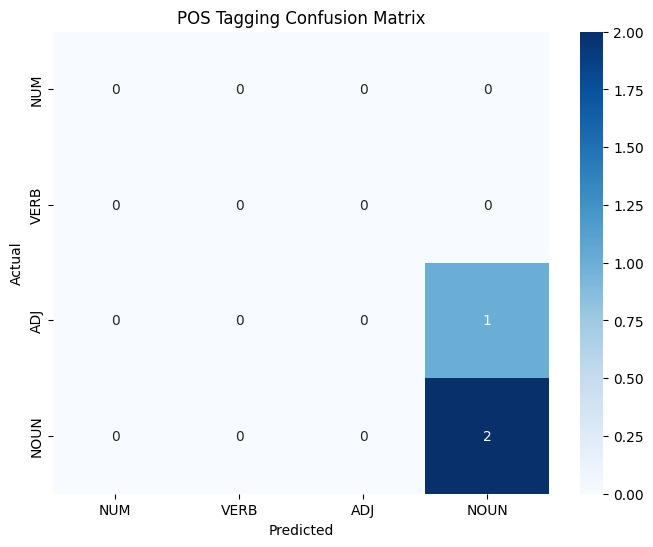


Predicted POS Tags:
বঙ্কিমচন্দ্র: NOUN
চট্টোপাধ্যায়: NOUN
জন্মগ্রহণ: VERB
করেন: VERB


In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn_crfsuite
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Sample labeled Bengali sentence for POS tagging
data = [
    ("বঙ্কিমচন্দ্র", "NOUN"),
    ("চট্টোপাধ্যায়", "NOUN"),
    ("২৬শে", "NUM"),
    ("জুন", "NOUN"),
    ("১৮৩৮", "NUM"),
    ("সালে", "NOUN"),
    ("পশ্চিমবঙ্গের", "ADJ"),
    ("চব্বিশ", "NUM"),
    ("পরগনা", "NOUN"),
    ("জেলার", "ADJ"),
    ("অন্তর্গত", "ADJ"),
    ("কীঠালপাড়া", "NOUN"),
    ("গ্রামে", "NOUN"),
    ("জন্মগ্রহণ", "VERB"),
    ("করেন", "VERB")
]

df = pd.DataFrame(data, columns=["Word", "POS"])

def extract_features(sentence, index):
    """Extract contextual features for a given word in a sentence."""
    word = sentence[index][0]
    prev_word = sentence[index-1][0] if index > 0 else "<START>"
    next_word = sentence[index+1][0] if index < len(sentence) - 1 else "<END>"

    features = {
        'word': word,
        'word_lower': word.lower(),
        'word_suffix': word[-3:] if len(word) > 3 else word,
        'prev_word': prev_word,
        'next_word': next_word,
        'word_length': len(word),
        'is_digit': word.isdigit(),
    }
    return features

# Prepare feature set and labels
X = [extract_features(df.values, i) for i in range(len(df))]
y = [pos for _, pos in df.values]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train CRF model
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1, c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit([X_train], [y_train])

# Predict POS tags
y_pred = crf.predict([X_test])[0]

# Generate classification report
print(classification_report(y_test, y_pred))

# Generate confusion matrix
labels = list(set(y))  # Unique POS tags
cm = confusion_matrix(y_test, y_pred, labels=labels)

# Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("POS Tagging Confusion Matrix")
plt.show()

# Test on a new sentence
test_sentence = ["বঙ্কিমচন্দ্র", "চট্টোপাধ্যায়", "জন্মগ্রহণ", "করেন"]
test_features = [extract_features([(word, '') for word in test_sentence], i) for i in range(len(test_sentence))]
test_pred = crf.predict([test_features])[0]

print("\nPredicted POS Tags:")
for word, pos in zip(test_sentence, test_pred):
    print(f"{word}: {pos}")


Perform POS tagging on Bengali text using a CRF model, evaluate results with classification metrics, and visualize the confusion matrix.

Classification Report:
              precision    recall  f1-score   support

         ADJ       0.00      0.00      0.00         1
        NOUN       0.67      1.00      0.80         2

    accuracy                           0.67         3
   macro avg       0.33      0.50      0.40         3
weighted avg       0.44      0.67      0.53         3



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


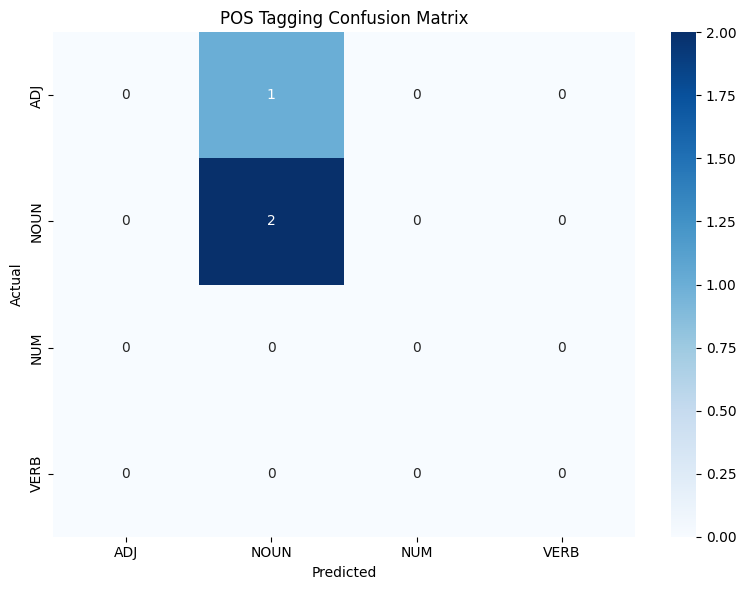


Predicted POS Tags:
বঙ্কিমচন্দ্র: NOUN
চট্টোপাধ্যায়: NOUN
জন্মগ্রহণ: VERB
করেন: VERB


In [ ]:
!pip install sklearn-crfsuite
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn_crfsuite
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
!pip install sklearn-crfsuite


# Sample labeled Bengali sentence for POS tagging
data = [
    ("বঙ্কিমচন্দ্র", "NOUN"),
    ("চট্টোপাধ্যায়", "NOUN"),
    ("২৬শে", "NUM"),
    ("জুন", "NOUN"),
    ("১৮৩৮", "NUM"),
    ("সালে", "NOUN"),
    ("পশ্চিমবঙ্গের", "ADJ"),
    ("চব্বিশ", "NUM"),
    ("পরগনা", "NOUN"),
    ("জেলার", "ADJ"),
    ("অন্তর্গত", "ADJ"),
    ("কীঠালপাড়া", "NOUN"),
    ("গ্রামে", "NOUN"),
    ("জন্মগ্রহণ", "VERB"),
    ("করেন", "VERB")
]

df = pd.DataFrame(data, columns=["Word", "POS"])

def extract_features(sentence, index):
    """Extract contextual features for a given word in a sentence."""
    word = sentence[index][0]
    prev_word = sentence[index-1][0] if index > 0 else "<START>"
    next_word = sentence[index+1][0] if index < len(sentence) - 1 else "<END>"

    features = {
        'word': word,
        'word_lower': word.lower(),
        'word_suffix': word[-3:] if len(word) > 3 else word,
        'prev_word': prev_word,
        'next_word': next_word,
        'word_length': len(word),
        'is_digit': word.isdigit(),
    }
    return features

# Prepare feature set and labels
X = [extract_features(df.values, i) for i in range(len(df))]
y = [pos for _, pos in df.values]

# Train-test split (ensure at least 2 samples in each set)
if len(X) > 2:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
else:
    X_train, X_test, y_train, y_test = X, X, y, y  # Fallback for tiny datasets

# Train CRF model
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1, c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit([X_train], [y_train])  # Ensure training data is wrapped in a list

# Predict POS tags
y_pred = crf.predict([X_test])[0]  # Extract predictions from list

# Generate classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Generate confusion matrix
labels = sorted(set(y))  # Ensure consistent label ordering
cm = confusion_matrix(y_test, y_pred, labels=labels)

# Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("POS Tagging Confusion Matrix")
plt.tight_layout()
plt.show()

# Test on a new sentence
test_sentence = ["বঙ্কিমচন্দ্র", "চট্টোপাধ্যায়", "জন্মগ্রহণ", "করেন"]
test_features = [extract_features([(word, '') for word in test_sentence], i) for i in range(len(test_sentence))]
test_pred = crf.predict([test_features])[0]

print("\nPredicted POS Tags:")
for word, pos in zip(test_sentence, test_pred):
    print(f"{word}: {pos}")


Train a CRF model for Bengali POS tagging, evaluate it using classification report and confusion matrix

In [19]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import RegexpParser

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# File path
input_file_path = "/content/drive/MyDrive/Enternyship/lemmatized_sentences_bangla.txt"
output_file_path = "/content/drive/MyDrive/Enternyship/chunking_output.txt"

# Read lemmatized words from a file
def read_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        return f.read()

# Read the input text
input_text = read_file(input_file_path)

# Tokenize the words
tokens = word_tokenize(input_text)

# POS to Bengali Tag Mapping
POS_TAG_MAP_BANGLA = {
    'NN': 'Noun',
    'NNS': 'Noun (Plural)',
    'NNP': 'Proper Noun',
    'NNPS': 'Proper Noun (Plural)',
    'VB': 'Verb',
    'VBD': 'Verb (Past)',
    'VBG': 'Verb (Gerund)',
    'VBN': 'Verb (Past Participle)',
    'VBP': 'Verb (Present)',
    'VBZ': 'Verb (3rd Person Present)',
    'JJ': 'Adjective',
    'JJR': 'Adjective (Comparative)',
    'JJS': 'Adjective (Superlative)',
    'RB': 'Adverb',
    'RBR': 'Adverb (Comparative)',
    'RBS': 'Adverb (Superlative)',
    'PRP': 'Pronoun',
    'PRP$': 'Pronoun (Possessive)',
    'WP': 'Wh-Pronoun',
    'WP$': 'Wh-Possessive',
    'WRB': 'Wh-Adverb',
    'IN': 'Preposition',
    'CC': 'Conjunction',
    'DT': 'Determiner',
    'UH': 'Interjection',
    'CD': 'Cardinal Number',
    'FW': 'Foreign Word',
    'MD': 'Modal',
}

# Apply POS tagging
def custom_pos_tagging(tokens):
    standard_pos_tags = nltk.pos_tag(tokens)  # POS tagging using NLTK
    custom_tags = [(word, POS_TAG_MAP_BANGLA.get(tag, 'Other')) for word, tag in standard_pos_tags]
    return custom_tags

# Apply POS tagging to the tokens
custom_pos_tags = custom_pos_tagging(tokens)

# Define chunking pattern
chunk_pattern = r"""
  NP: {<DT>?<JJ>*<NN>}      # Noun Phrase (optional Determiner, adjectives, and nouns)
  VP: {<VB.*><NP>}           # Verb Phrase (Verb followed by Noun Phrase)
  PP: {<IN><NP>}             # Prepositional Phrase (Preposition followed by Noun Phrase)
"""

# Chunking using NLTK's RegexpParser
chunker = RegexpParser(chunk_pattern)
chunk_output = chunker.parse(custom_pos_tags)

# Save chunking output to a file
def save_to_file(data, file_name, beautiful=False):
    with open(file_name, 'w', encoding='utf-8') as f:
        if beautiful and isinstance(data, nltk.tree.Tree):  # Check if it's a chunk tree
            f.write(str(data))
        else:
            f.write(str(data))

# Save chunking output
save_to_file(chunk_output, output_file_path, beautiful=True)

# Optionally, visualize the chunk tree (remove the comment to display it)
# chunk_output.draw()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
